In [5]:
import torch
import torch.nn as nn
torch.autograd.set_detect_anomaly(True)

In [76]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms

dataset_storage_directory = './mnist_dataset'
image_resolution = (28, 28)

mnist_dataset = datasets.MNIST(
    root=dataset_storage_directory,
    train=True,
    transform=transforms.Compose([
        transforms.Resize(image_resolution),
        transforms.ToTensor()
    ]),
    download=True
)
from torch.utils.data import DataLoader

batch_size = 64
indices_of_digit_1 = [i for i, label in enumerate(mnist_dataset.targets) if label == 1]

# Create a subset of the dataset for digit '1' only
#mnist_dataset = Subset(mnist_dataset, indices_of_digit_1)
dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


In [77]:
class Generator(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(Generator, self).__init__()
    self.input_layer = nn.Linear(input_dim, 256)
    self.batch_norm1 = nn.BatchNorm1d(256)
    self.layer_norm1 = nn.LayerNorm(256)
    self.relu1 = nn.LeakyReLU()
    self.hidden_layer_1 = nn.Linear(256, 256)
    self.batch_norm2 = nn.BatchNorm1d(256)
    self.layer_norm2 = nn.LayerNorm(256)
    self.relu2 = nn.LeakyReLU()
    self.hidden_layer_2 = nn.Linear(256, 512)
    self.batch_norm3 = nn.BatchNorm1d(512)
    self.layer_norm3 = nn.LayerNorm(512)
    self.relu3 = nn.LeakyReLU()
    self.hidden_layer_3 = nn.Linear(512, 1024)
    self.batch_norm4 = nn.BatchNorm1d(1024)
    self.layer_norm4 = nn.LayerNorm(1024)
    self.relu4 = nn.LeakyReLU()
    self.hidden_layer_4 = nn.Linear(1024, 2048)
    self.batch_norm5 = nn.BatchNorm1d(2048)
    self.layer_norm5 = nn.LayerNorm(2048)
    self.relu5 = nn.LeakyReLU()
    self.hidden_layer_5 = nn.Linear(2048, 1024)
    self.batch_norm6 = nn.BatchNorm1d(1024)
    self.layer_norm6 = nn.LayerNorm(1024)
    self.relu6 = nn.LeakyReLU()
    self.hidden_layer_6 = nn.Linear(1024, output_dim)
    self.sigmoid = nn.Sigmoid()
  def forward(self, x, apply_sigmoid=False):
    x = self.input_layer(x)
    #x = self.batch_norm1(x)
    x = self.layer_norm1(x)
    x = self.relu1(x)
    x = self.hidden_layer_1(x)
    #x = self.batch_norm2(x)
    x = self.layer_norm2(x)
    x = self.relu2(x)
    x = self.hidden_layer_2(x)
    #x = self.batch_norm3(x)
    x = self.layer_norm3(x)
    x = self.relu3(x)
    x = self.hidden_layer_3(x)
    #x = self.batch_norm4(x)
    x = self.layer_norm4(x)
    x = self.relu4(x)
    x = self.hidden_layer_4(x)
    #x = self.batch_norm5(x)
    x = self.layer_norm5(x)
    x = self.relu5(x)
    x = self.hidden_layer_5(x)
    #x = self.batch_norm6(x)
    x = self.layer_norm6(x)
    x = self.relu6(x)
    x = self.hidden_layer_6(x)
    if apply_sigmoid:
      x = self.sigmoid(x)
    return x
class Discriminator(nn.Module):
  def __init__(self, input_dim, output_dim=1):
    super(Discriminator, self).__init__()
    self.input_layer = nn.Linear(input_dim, 256)
    self.relu1 = nn.ReLU()
    self.relu1 = nn.LeakyReLU()
    self.hidden_layer_1 = nn.Linear(256, 512)
    self.relu2 = nn.ReLU()
    self.relu2 = nn.LeakyReLU()
    self.hidden_layer_2 = nn.Linear(512, 512)
    # # self.batch_norm = nn.BatchNorm1d(512)
    self.dropout = nn.Dropout(p=0.5)
    self.relu3 = nn.ReLU()
    self.relu3 = nn.LeakyReLU()
    self.hidden_layer_3 = nn.Linear(512, output_dim)
    # self.sigmoid = nn.Sigmoid()
  def forward(self, x):
    x = self.input_layer(x)
    x = self.relu1(x)
    x = self.hidden_layer_1(x)
    # x = self.batch_norm(x)
    x = self.relu2(x)
    x = self.dropout(x)
    x = self.hidden_layer_2(x)
    x = self.relu3(x)
    x = self.hidden_layer_3(x)
    return x

In [79]:
# def fake_loss(fake_image_discrimination):
#     gan_score = torch.log(1 - fake_image_discrimination)
#     gan_score = -1 * gan_score
#     return gan_score.mean()

# def real_loss(real_image_discrimination):
#     gan_score = torch.log(fake_image_discrimination)
#     gan_score = -1 * gan_score
#     return gan_score.mean()
def discrim_loss_func(real_image_discrimination, fake_image_discrimination):
    gan_score = torch.log(fake_image_discrimination) + torch.log(1 - real_image_discrimination)
    return gan_score.mean()

def discriminator_loss_func(real_image_discrimination, fake_image_discrimination):
    #print(real_image_discrimination, fake_image_discrimination)
    #real_targets = torch.ones_like(real_image_discrimination)
    real_targets = torch.full_like(real_image_discrimination, 0.9)
    #fake_targets = torch.zeros_like(fake_image_discrimination
    fake_targets = torch.zeros_like(fake_image_discrimination)
    # real_loss = torch.nn.functional.binary_cross_entropy(real_image_discrimination, real_targets)
    # fake_loss = torch.nn.functional.binary_cross_entropy(fake_image_discrimination, fake_targets)
    real_loss = torch.nn.functional.binary_cross_entropy_with_logits(real_image_discrimination, real_targets)
    fake_loss = torch.nn.functional.binary_cross_entropy_with_logits(fake_image_discrimination, fake_targets)

    return real_loss + fake_loss
def discriminator_loss_wasserstein(real_image_discrimination, fake_image_discrimination):
    return -(real_image_discrimination.mean() - fake_image_discrimination.mean())
def generator_loss_func(fake_image_discrimination):
    gan_score = torch.log(fake_image_discrimination)
    gan_score = -1 * gan_score
    return gan_score.mean()
def generator_loss_func(fake_image_discrimination):
    #return torch.nn.functional.binary_cross_entropy(fake_image_discrimination, torch.ones_like(fake_image_discrimination))
    #return torch.nn.functional.binary_cross_entropy_with_logits(fake_image_discrimination, torch.ones_like(fake_image_discrimination))
    return torch.nn.functional.binary_cross_entropy_with_logits(fake_image_discrimination, torch.full_like(fake_image_discrimination, 1))
def generator_loss_wasserstein(fake_image_discrimination):
    return -fake_image_discrimination.mean()
EPOCHS = 30
device = 'cuda' if torch.cuda.is_available() else 'cpu'
generator = Generator(100, 784).to(device)
discriminator = Discriminator(784, 1).to(device)
def weights_init(module):
    if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, 0.0, 0.02)
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)

generator.apply(weights_init)
discriminator.apply(weights_init)
from tqdm.notebook import tqdm
#optimizer = torch.optim.Adam(list(generator.parameters()) + list(discriminator.parameters()), lr=0.03)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.00005)
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=0.00005)
for i in range(0, EPOCHS):
  for real_images_batch, _ in tqdm(dataloader, desc=f"Epoch {i+1}"):
    real_images_batch = real_images_batch.to(device)
    real_images_batch = real_images_batch.float()
    real_images_batch = torch.flatten(real_images_batch, start_dim=1)
    for _ in range(5):
        fake_images_noise_batch = torch.randn(batch_size, 100).to(device)
        generated_fake_images = generator(fake_images_noise_batch).detach()
        real_image_discrimination = discriminator(real_images_batch)
        fake_image_discrimination = discriminator(generated_fake_images)
        # fake_loss = fake_loss(fake_image_discrimination)
        # real_loss = real_loss(real_image_discrimination)
        discrim_loss = discriminator_loss_wasserstein(real_image_discrimination, fake_image_discrimination)
        for parameter in discriminator.parameters():
            parameter.data.clamp(-0.01, 0.01)

        #loss = discrim_loss_func(real_image_discrimination, fake_image_discrimination)
        #loss = gan_loss_function(fake_image_discrimination, real_image_discrimination)
        #optimizer.zero_grad()
        disc_optimizer.zero_grad()
        discrim_loss.backward()
        disc_optimizer.step()

    for _ in range(1):
        fake_images_noise_batch = torch.randn(batch_size, 100).to(device)
        generated_fake_images = generator(fake_images_noise_batch)
        fake_image_discrimination = discriminator(generated_fake_images)
        generator_loss = generator_loss_wasserstein(fake_image_discrimination)
        gen_optimizer.zero_grad()
        generator_loss.backward()
        # fake_loss.backward()
        # real_loss.backward()
        print(generator_loss, discrim_loss)
        gen_optimizer.step()
        #optimizer.step()

Epoch 1:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(0.0259, grad_fn=<NegBackward0>) tensor(-0.0217, grad_fn=<NegBackward0>)
tensor(0.0324, grad_fn=<NegBackward0>) tensor(-0.0336, grad_fn=<NegBackward0>)
tensor(0.0353, grad_fn=<NegBackward0>) tensor(-0.0461, grad_fn=<NegBackward0>)
tensor(0.0406, grad_fn=<NegBackward0>) tensor(-0.0630, grad_fn=<NegBackward0>)
tensor(0.0492, grad_fn=<NegBackward0>) tensor(-0.0898, grad_fn=<NegBackward0>)
tensor(0.0640, grad_fn=<NegBackward0>) tensor(-0.1260, grad_fn=<NegBackward0>)
tensor(0.0831, grad_fn=<NegBackward0>) tensor(-0.1818, grad_fn=<NegBackward0>)
tensor(0.1125, grad_fn=<NegBackward0>) tensor(-0.2507, grad_fn=<NegBackward0>)
tensor(0.1427, grad_fn=<NegBackward0>) tensor(-0.3807, grad_fn=<NegBackward0>)
tensor(0.1950, grad_fn=<NegBackward0>) tensor(-0.5045, grad_fn=<NegBackward0>)
tensor(0.2636, grad_fn=<NegBackward0>) tensor(-0.7335, grad_fn=<NegBackward0>)
tensor(0.3393, grad_fn=<NegBackward0>) tensor(-1.0318, grad_fn=<NegBackward0>)
tensor(0.4523, grad_fn=<NegBackward0>) tensor(-1.327

Epoch 2:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(6483.6782, grad_fn=<NegBackward0>) tensor(-1126.1270, grad_fn=<NegBackward0>)
tensor(6342.8999, grad_fn=<NegBackward0>) tensor(-1398.2212, grad_fn=<NegBackward0>)
tensor(6197.0146, grad_fn=<NegBackward0>) tensor(-1214.7329, grad_fn=<NegBackward0>)
tensor(6044.0947, grad_fn=<NegBackward0>) tensor(-1313.8340, grad_fn=<NegBackward0>)
tensor(6001.8730, grad_fn=<NegBackward0>) tensor(-1854.7676, grad_fn=<NegBackward0>)
tensor(6141.1431, grad_fn=<NegBackward0>) tensor(-1505.9155, grad_fn=<NegBackward0>)
tensor(6464.0806, grad_fn=<NegBackward0>) tensor(-1901.3066, grad_fn=<NegBackward0>)
tensor(6710.9375, grad_fn=<NegBackward0>) tensor(-2447.2642, grad_fn=<NegBackward0>)
tensor(6686.8945, grad_fn=<NegBackward0>) tensor(-2677.2834, grad_fn=<NegBackward0>)
tensor(6778.3301, grad_fn=<NegBackward0>) tensor(-3272.3064, grad_fn=<NegBackward0>)
tensor(6713.6436, grad_fn=<NegBackward0>) tensor(-3344.7095, grad_fn=<NegBackward0>)
tensor(6430.1265, grad_fn=<NegBackward0>) tensor(-3384.5305, grad

KeyboardInterrupt: 

In [80]:
z1 = torch.randn(64, 100).to(device)
z2 = torch.randn(64, 100).to(device)
out1 = generator(z1, apply_sigmoid=True)
out2 = generator(z2, apply_sigmoid=True)
print(torch.norm(out1 - out2))

tensor(0.0813, grad_fn=<LinalgVectorNormBackward0>)


tensor([[-1.2871,  0.6060,  1.0735,  ...,  1.0733,  0.1523,  0.7747],
        [-0.8514,  0.3717,  1.0729,  ...,  0.8359,  1.7276,  0.2194],
        [-1.7104,  0.5223,  1.8814,  ..., -1.4426,  0.3902,  0.4782],
        ...,
        [ 0.4928, -0.2693, -1.1507,  ...,  1.3236,  1.6895, -2.1138],
        [-0.8568,  0.8236,  0.8338,  ...,  0.5570, -0.1079, -0.2394],
        [-0.2526,  0.6976,  1.9857,  ...,  0.2549,  1.3727,  0.7592]])
[[-1.98796391e-01  8.43476892e-01  3.83787483e-01  1.03678763e-01
  -6.06345713e-01  4.42432195e-01 -9.61461186e-01 -3.93187225e-01
  -1.32699624e-01 -4.99143600e-01 -1.64896226e+00 -5.23900330e-01
  -6.81094229e-01 -5.16128540e-01 -1.51295650e+00 -5.76886773e-01
  -2.97665864e-01 -1.04406118e+00  6.67278409e-01  1.07353576e-01
   1.89882711e-01  2.56863713e-01  4.49774921e-01  3.12589735e-01
   5.44817030e-01  1.99662536e-01 -2.55701959e-01  8.60340059e-01]
 [-4.72269893e-01 -1.10004604e+00 -3.90618622e-01 -1.67851579e+00
   1.06409097e+00  3.24699700e-01 -4.

<Figure size 640x480 with 0 Axes>

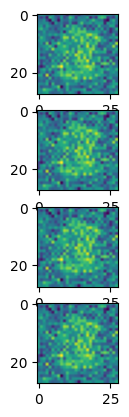

In [83]:
random_noise = torch.randn(64, 100).to(device)
print(random_noise)
fake_images = generator(random_noise, apply_sigmoid=True)
import matplotlib.pyplot as plt
print(fake_images[0].cpu().view(28,28).detach().numpy())
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(4,1)
axarr[0].imshow(fake_images[0].cpu().view(28,28).detach().numpy())
axarr[1].imshow(fake_images[1].cpu().view(28,28).detach().numpy())
axarr[2].imshow(fake_images[2].cpu().view(28,28).detach().numpy())
axarr[3].imshow(fake_images[3].cpu().view(28,28).detach().numpy())

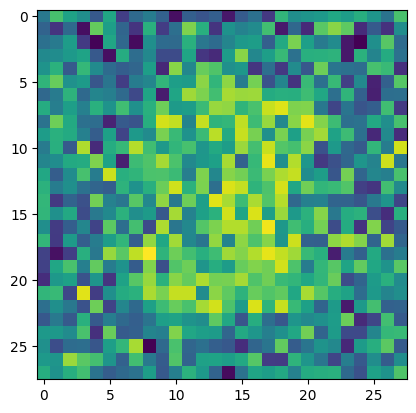

In [82]:
import matplotlib.pyplot as plt
plt.imshow(fake_images[10].cpu().view(28,28).detach().numpy())

In [68]:
discriminator(fake_images)

tensor([[-4.7459e+08],
        [-4.6853e+08],
        [-4.9803e+08],
        [-4.4157e+08],
        [-4.5442e+08],
        [-4.4665e+08],
        [-4.3216e+08],
        [-4.6429e+08],
        [-4.2193e+08],
        [-4.3391e+08],
        [-4.5946e+08],
        [-4.0480e+08],
        [-4.2190e+08],
        [-4.6631e+08],
        [-4.7093e+08],
        [-4.5912e+08],
        [-4.6774e+08],
        [-4.6131e+08],
        [-4.3426e+08],
        [-4.4171e+08],
        [-4.2439e+08],
        [-4.7284e+08],
        [-4.9344e+08],
        [-4.6645e+08],
        [-4.6531e+08],
        [-4.0894e+08],
        [-4.3798e+08],
        [-4.7852e+08],
        [-4.2287e+08],
        [-4.5498e+08],
        [-4.4027e+08],
        [-4.7080e+08],
        [-4.7110e+08],
        [-4.4920e+08],
        [-4.6250e+08],
        [-4.8323e+08],
        [-4.6865e+08],
        [-4.3479e+08],
        [-4.3399e+08],
        [-4.6753e+08],
        [-4.8305e+08],
        [-4.6465e+08],
        [-4.5190e+08],
        [-5

In [69]:
discriminator(real_images_batch)

tensor([[-9.1998e+07],
        [-7.9591e+07],
        [-9.8696e+07],
        [-8.8513e+07],
        [-9.0874e+07],
        [-8.2490e+07],
        [-8.7810e+07],
        [-8.6415e+07],
        [-1.0806e+08],
        [-9.0684e+07],
        [-8.3539e+07],
        [-8.9739e+07],
        [-8.7239e+07],
        [-1.1868e+08],
        [-9.5277e+07],
        [-9.0606e+07],
        [-9.3183e+07],
        [-1.1189e+08],
        [-9.1122e+07],
        [-9.6687e+07],
        [-8.7352e+07],
        [-9.3293e+07],
        [-9.2203e+07],
        [-1.0109e+08],
        [-8.3674e+07],
        [-8.4454e+07],
        [-8.0646e+07],
        [-8.7610e+07],
        [-9.4059e+07],
        [-8.0704e+07],
        [-9.3253e+07],
        [-9.1251e+07],
        [-8.2318e+07],
        [-1.0569e+08],
        [-8.6634e+07],
        [-9.4716e+07],
        [-9.3236e+07],
        [-8.7609e+07],
        [-9.9168e+07],
        [-1.0248e+08],
        [-8.8993e+07],
        [-9.7074e+07],
        [-9.3131e+07],
        [-9

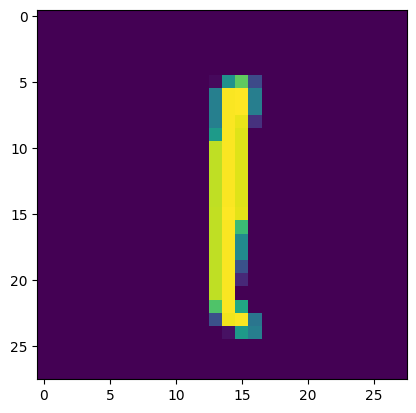

In [70]:
plt.imshow(real_images_batch[3].cpu().view(28,28).detach().numpy())

In [ ]:
fake_images

tensor([[-2.6380e-04,  3.0969e-01,  4.9178e-02, -9.9666e-02, -1.0710e-01,
         -2.0845e-02, -1.8778e-01, -1.3405e-01,  1.9546e-01, -8.2217e-02,
          1.9925e-02, -1.4420e-01, -1.1873e-02,  1.4157e-02,  1.2275e-02,
          1.6401e-01, -3.0275e-02, -1.4585e-02,  3.6288e-02, -6.2536e-03,
         -2.0770e-02,  2.2714e-02, -1.0382e-02,  5.1561e-02,  2.5083e-02,
          6.1741e-02,  2.3672e-01, -3.6556e-02,  9.3411e-03,  1.9379e-02,
          1.1338e-01, -2.9353e-01, -1.2177e-02,  8.1017e-02, -2.8918e-02,
          1.1052e-01,  1.4369e-01, -2.2652e-02,  3.3090e-02,  1.1570e-01,
         -1.2840e-01,  1.7496e-02, -1.1618e-01,  6.6575e-02, -1.5959e-01,
          3.4487e-02,  8.8767e-02,  1.4464e-01, -1.5867e-01, -7.4282e-03,
         -4.0023e-03,  1.0963e-01, -1.5528e-01, -1.8090e-02, -2.3274e-03,
         -2.4251e-01,  1.5543e-01, -5.2449e-02,  1.0918e-01,  7.9559e-02,
         -1.2769e-01,  2.8001e-02,  6.6455e-02, -3.0793e-02,  4.3907e-02,
         -3.7824e-02,  4.0585e-02, -1.

In [ ]:
real_images_batch[10].cpu().view(28,28).detach().numpy()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    